# Broadcast Analysis

Analysis of different `MPI_Bcast` algorithms om `AMD EPYC 7H12` processors.\
The analysis aims to fit the data with a generalized linear model and compare with the point-to-point model built in Python.

In [1]:
# Load modules
from utils import *
from epyc import *
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
import pandas as pd
import os

# Current working directory
cwd = os.getcwd()

# Broadcast data
node_file = os.path.join(cwd, '../datasets/bcast_node.csv')
socket_file = os.path.join(cwd, '../datasets/bcast_socket.csv')
core_file = os.path.join(cwd, '../datasets/bcast_core.csv')

# Create the node objects
node1 = Node()
node2 = Node()

# Common measures for the plots
fontsize = 20
width = 8
height = 6

***

## Algorithm 0: Default

### EDA

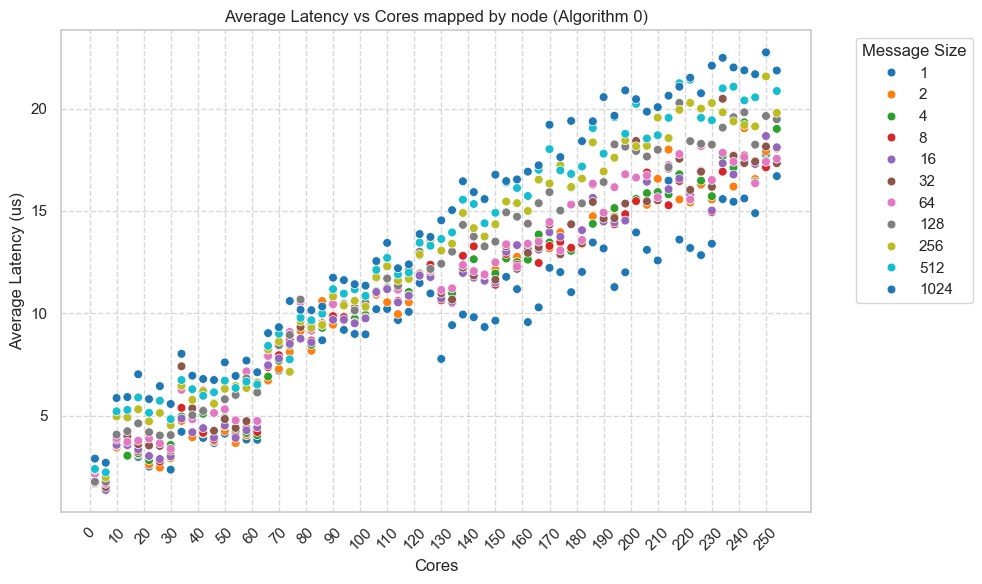

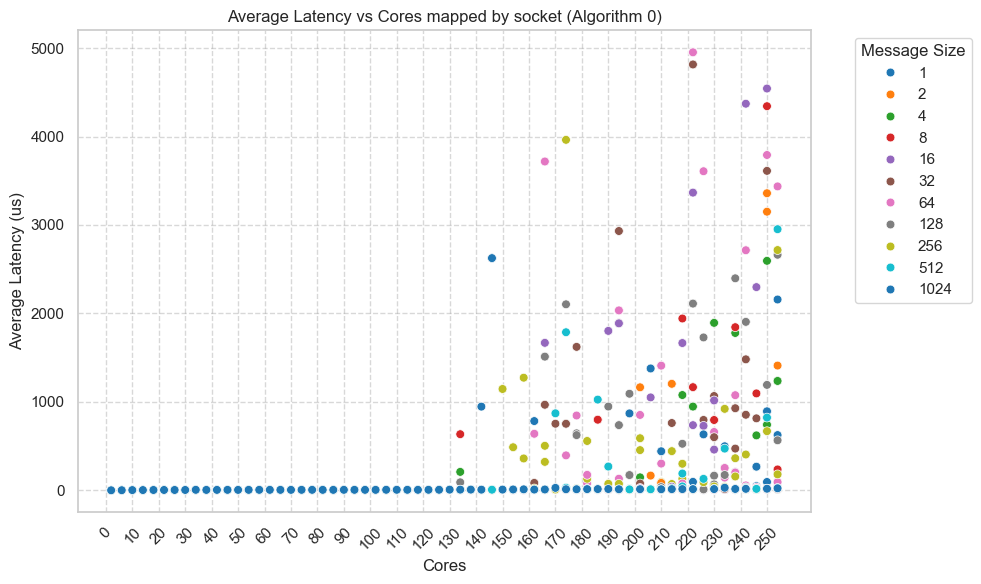

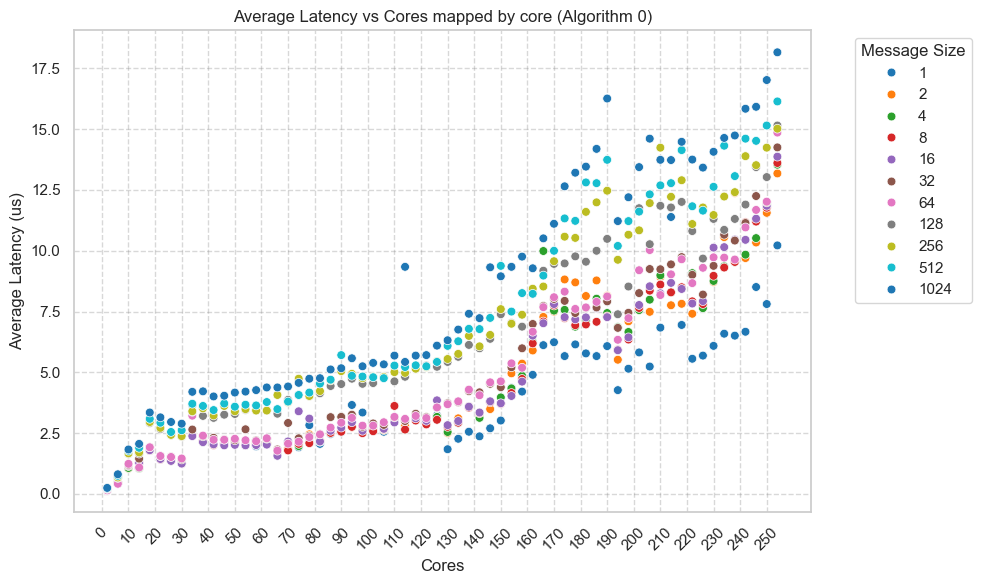

In [2]:
dfn = preproc(node_file, 'node', 0)
dfs = preproc(socket_file, 'socket', 0)
dfc = preproc(core_file, 'core', 0)

sizestop = 1024
latency_vs_cores(dfn[dfn['size']<=sizestop], '0', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '0', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '0', 'core')

### Data cleaning

In [ ]:
# Cleaning visualization
# sizestart = 4096
# sizestop = 8192
# cut = 100
# latency_vs_cores(dfs[((dfs['size']>=sizestart) & (dfs['size']<=sizestop) & (dfs['latency']<=cut))], '0', 'socket')

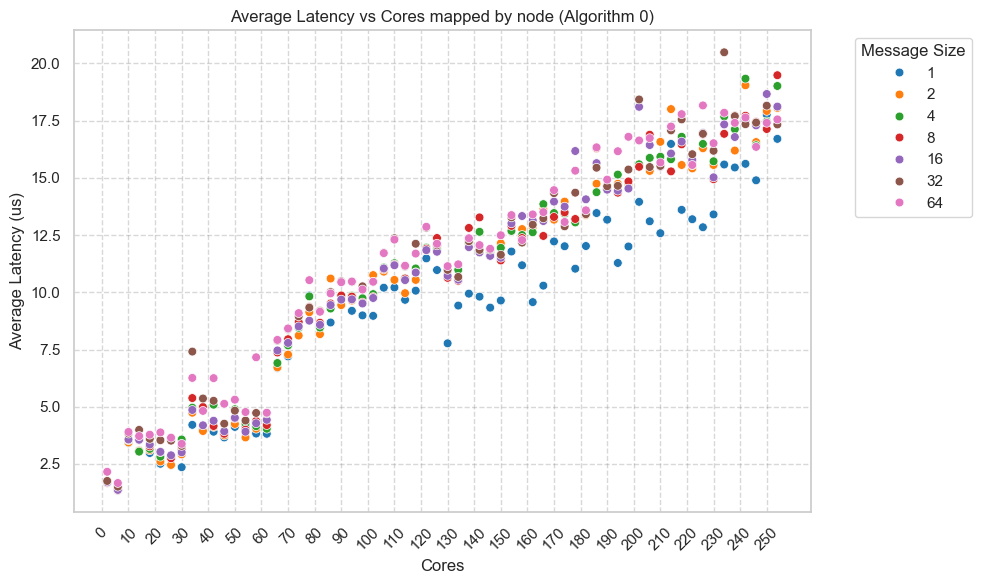

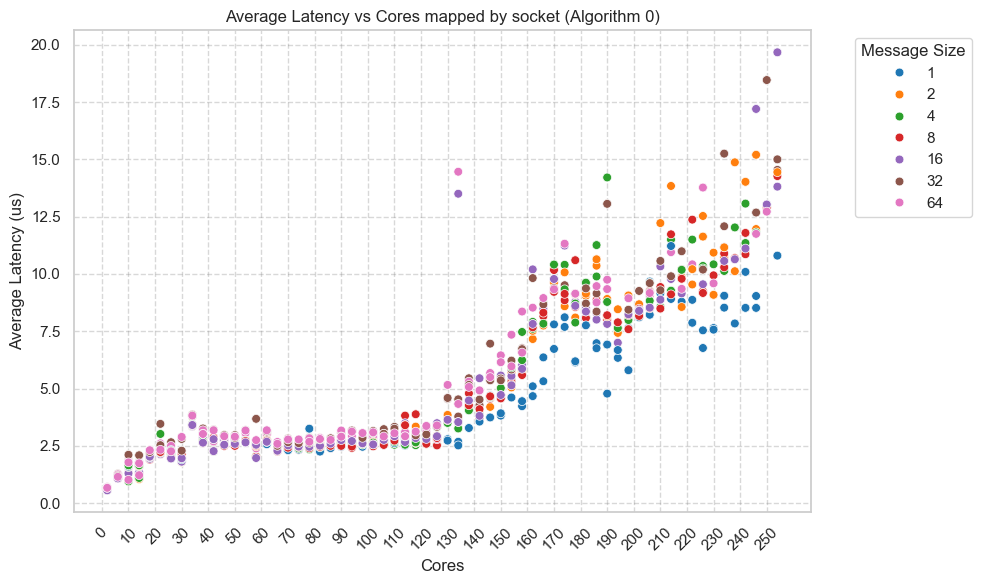

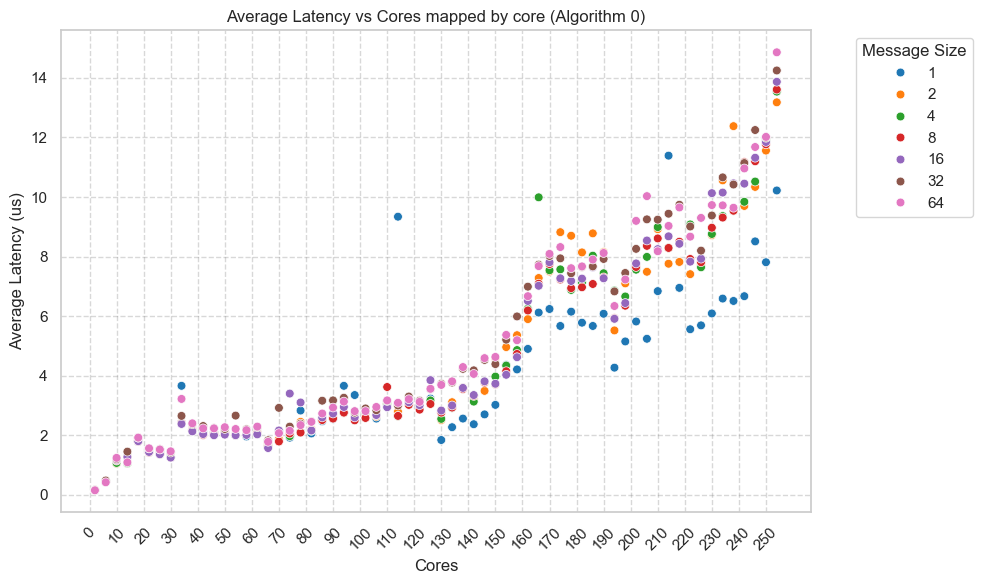

In [3]:
# Remove outliers in dfs
dfs = dfs[~((dfs['size']<=128) & (dfs['latency']>20))]
dfs = dfs[~((dfs['size']>=256) & (dfs['size']<=512) & (dfs['latency']>17.5))]
dfs = dfs[~((dfs['size']>=1024) & (dfs['size']<=2048) & (dfs['latency']>25))]
dfs = dfs[~((dfs['size']>=4096) & (dfs['size']<=8192) & (dfs['latency']>60))]

# Check
sizestop = 64
latency_vs_cores(dfn[dfn['size']<=sizestop], '0', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '0', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '0', 'core')

### Linear Fit

#### Core

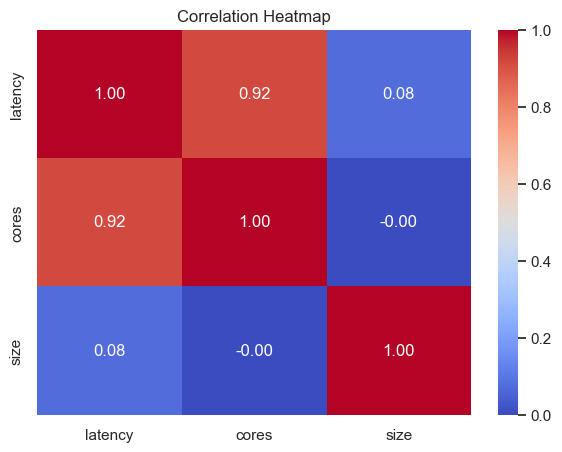

In [6]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfc[dfc['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [8]:
# Linear Fit
df = dfc.copy()

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     2296.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          5.17e-178
Time:                        09:22:47   Log-Likelihood:                -752.54
No. Observations:                 448   AIC:                             1509.
Df Residuals:                     446   BIC:                             1517.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3670      0.123     -2.985      0.0

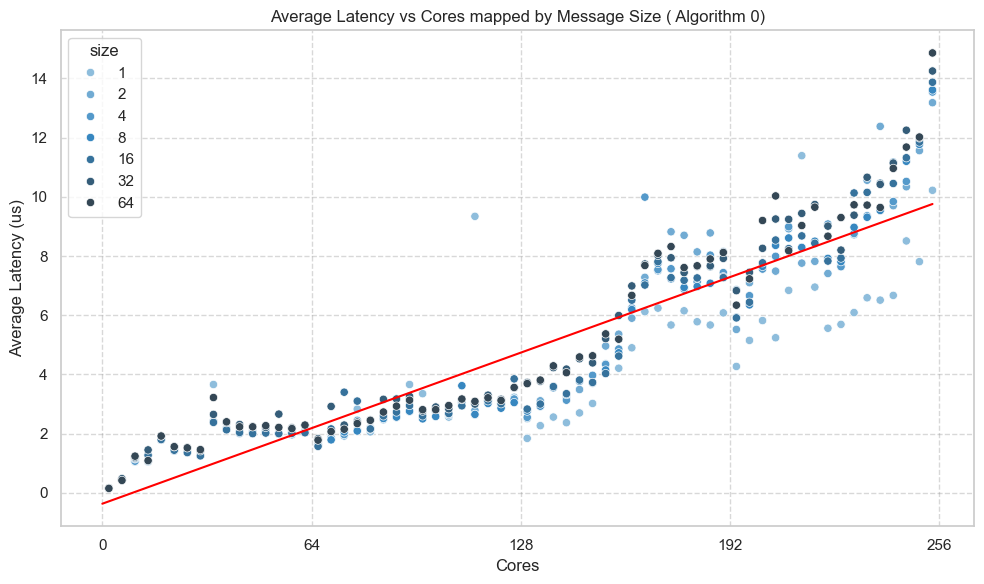

In [9]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
x = np.linspace(0, 254, 100)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red')

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size ( Algorithm 0)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Socket

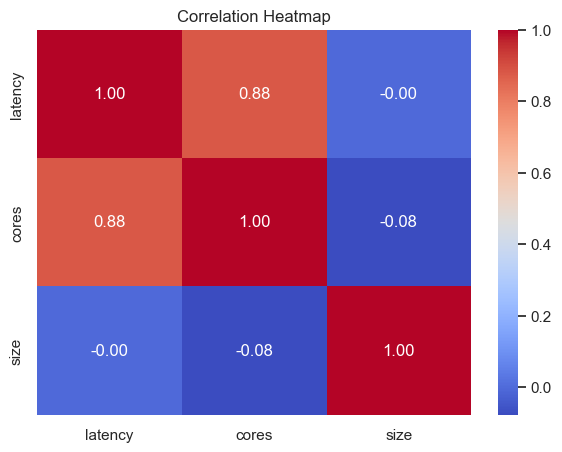

In [10]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfs[dfs['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [11]:
# Linear Fit
df = dfs.copy()

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.775
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     4122.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:23:21   Log-Likelihood:                -2292.2
No. Observations:                1199   AIC:                             4588.
Df Residuals:                    1197   BIC:                             4599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1115      0.092     -1.211      0.2

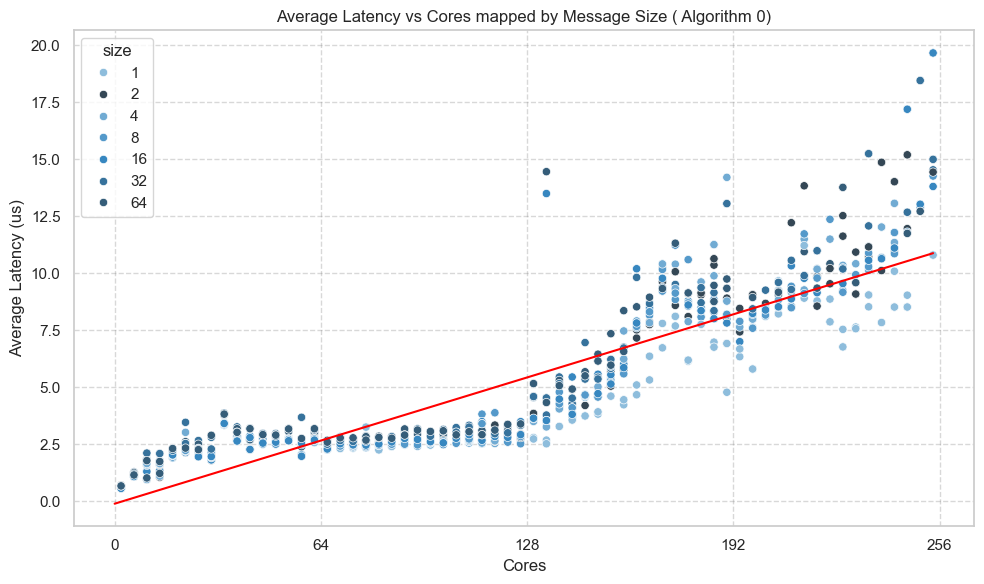

In [12]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
x = np.linspace(0, 254, 100)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red')

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size ( Algorithm 0)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Node

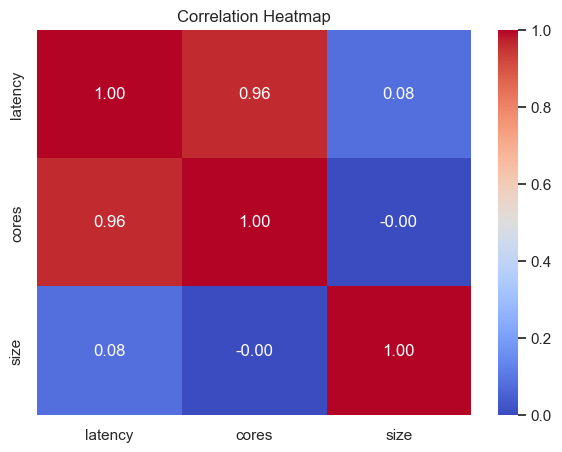

In [13]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfn[dfn['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [14]:
# Linear Fit
df = dfn.copy()

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     5677.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          8.00e-256
Time:                        09:23:39   Log-Likelihood:                -753.75
No. Observations:                 448   AIC:                             1511.
Df Residuals:                     446   BIC:                             1520.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6002      0.123     21.094      0.0

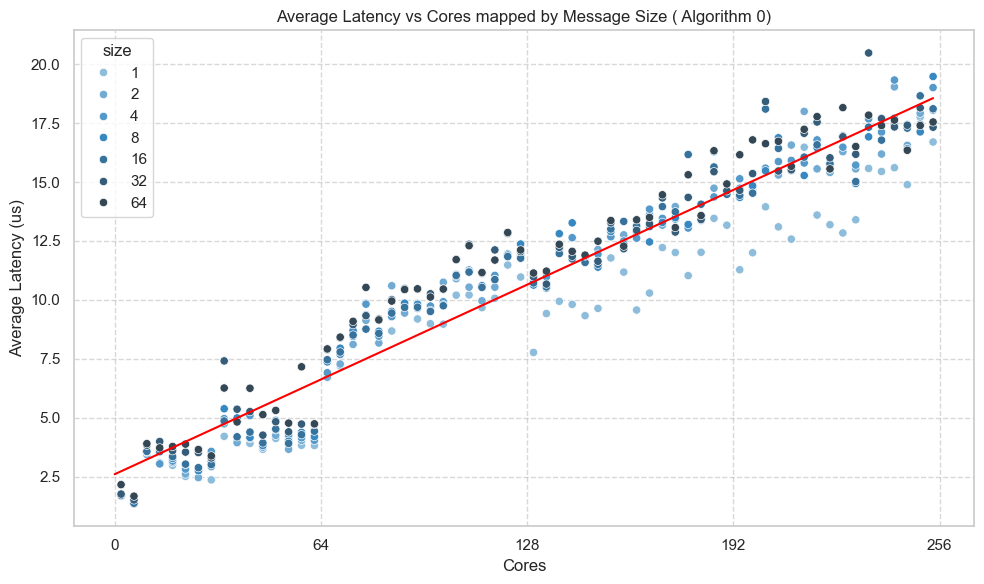

In [15]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
x = np.linspace(0, 254, 100)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red')

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size ( Algorithm 0)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

***

## Algorithm 1: Linear

### EDA

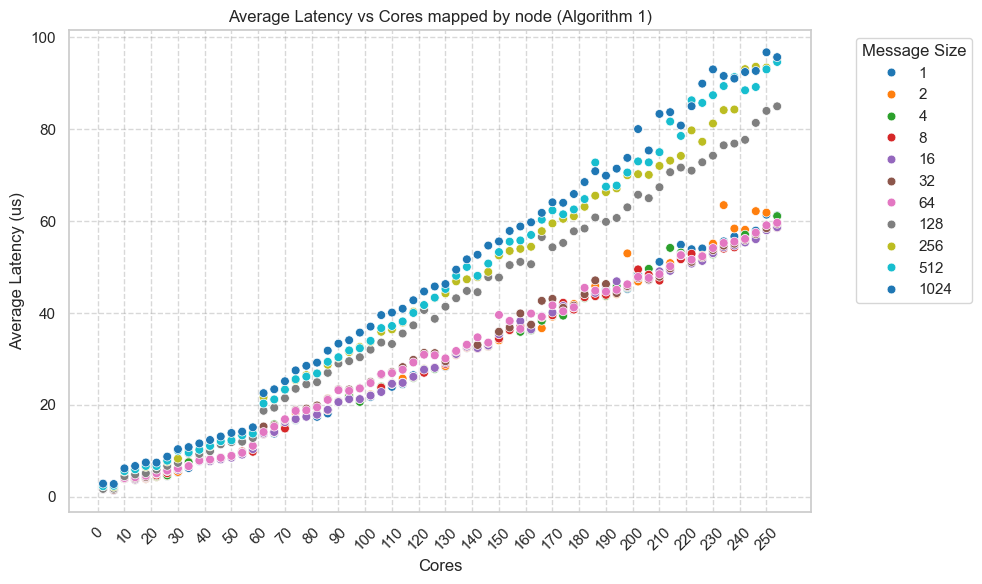

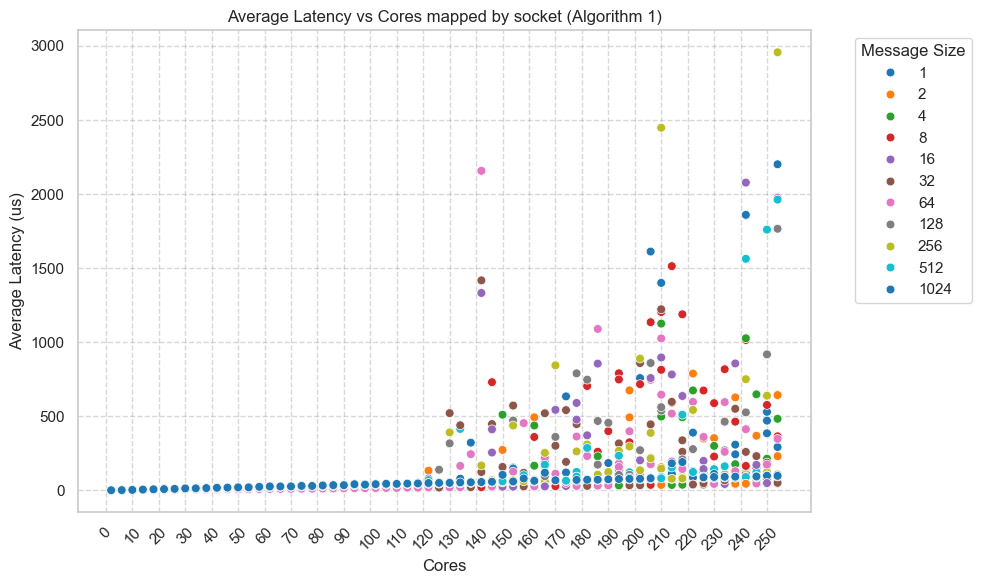

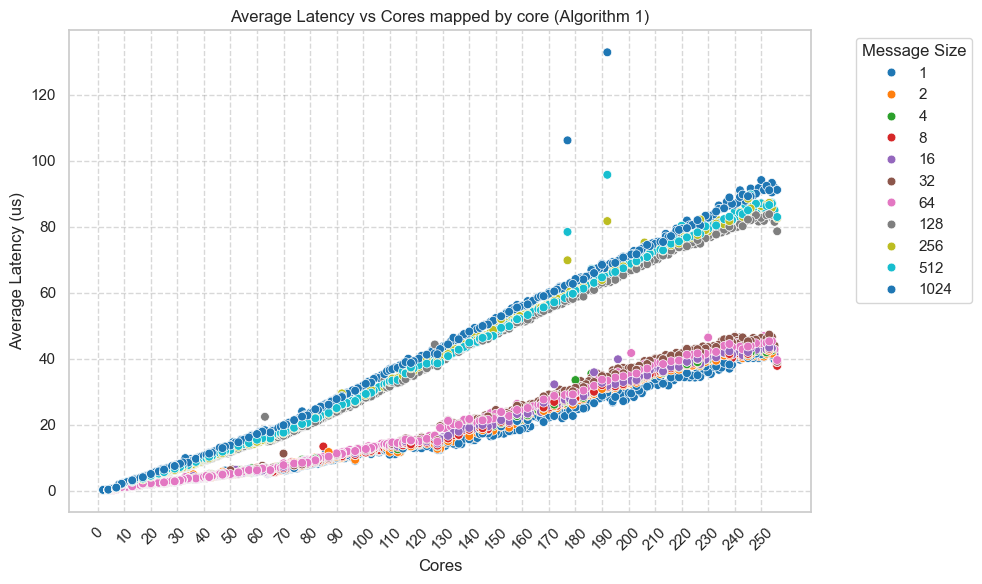

In [2]:
dfn = preproc(node_file, 'node', 1)
dfs = preproc(socket_file, 'socket', 1)
dfc = preproc(core_file, 'core', 1)

sizestop = 1024
latency_vs_cores(dfn[dfn['size']<=sizestop], '1', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '1', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '1', 'core')

### Data cleaning

In [ ]:
# Cleaning visualization
# sizestart = 0
# sizestop = 64
# cut = 50
# latency_vs_cores(dfs[((dfs['size']>=sizestart) & (dfs['size']<=sizestop) & (dfs['latency']<=cut))], '0', 'socket')

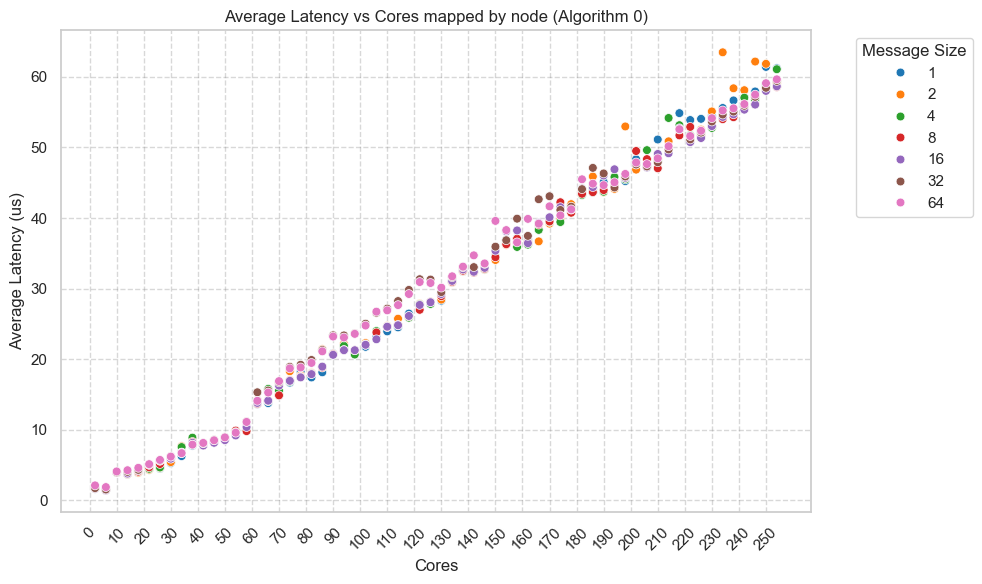

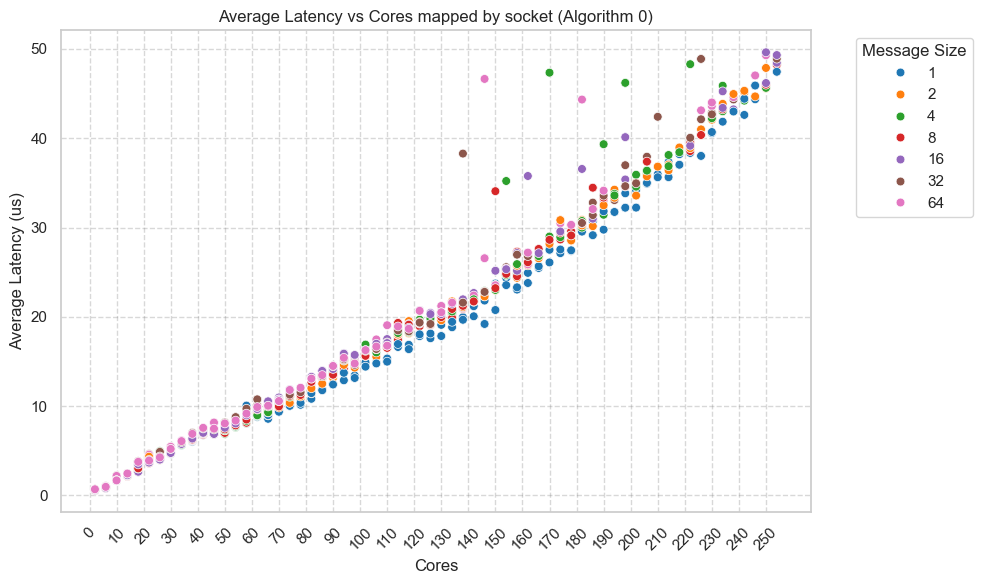

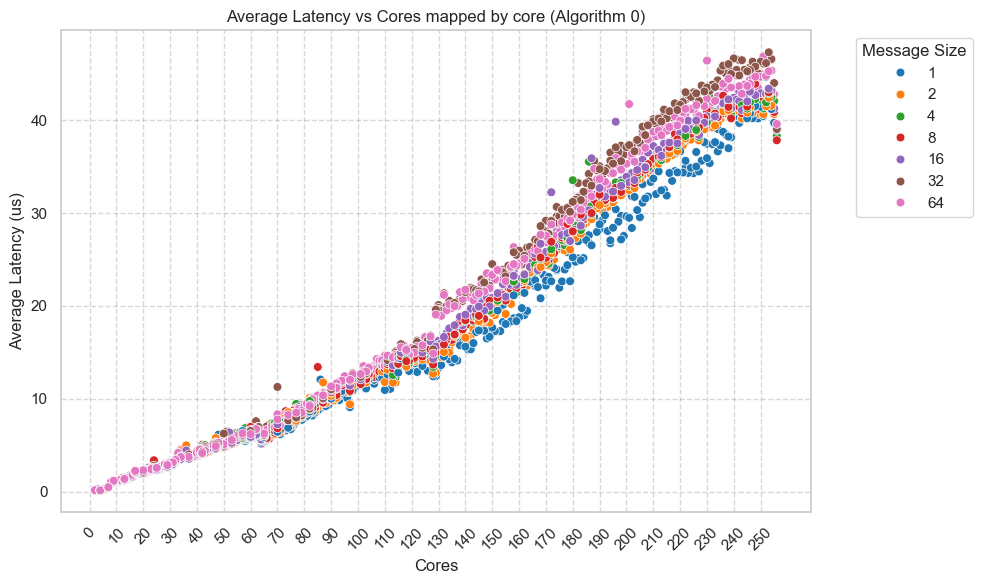

In [3]:
# Remove outliers in dfs
dfs = dfs[~((dfs['size']<=64) & (dfs['latency']>50))]
# dfs = dfs[~((dfs['size']>=256) & (dfs['size']<=512) & (dfs['latency']>17.5))]
# dfs = dfs[~((dfs['size']>=1024) & (dfs['size']<=2048) & (dfs['latency']>25))]
# dfs = dfs[~((dfs['size']>=4096) & (dfs['size']<=8192) & (dfs['latency']>60))]

# Check
sizestop = 64
latency_vs_cores(dfn[dfn['size']<=sizestop], '0', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '0', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '0', 'core')

### Linear Fit

#### Core

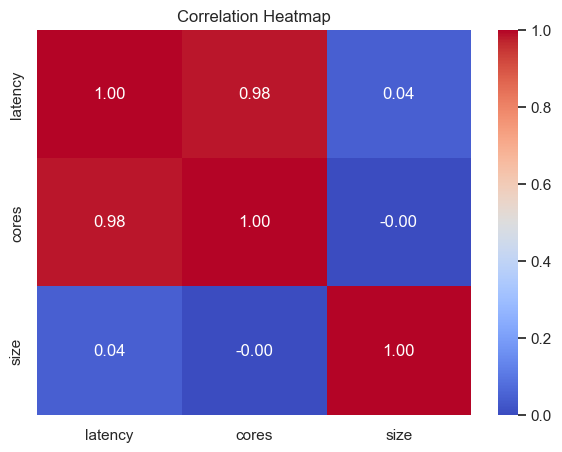

In [21]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfc[dfc['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [4]:
# Linear Fit -------------------------------------------------------------------
df = dfc.copy()

# ------------------------------------------------------------------------------

# # Group by the node:
# # Add a categorical column to group depending on the cores
# df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
# df['group'] = df['group'].astype('category')

# # Create dummy variables for the 'group' column
# group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
# df = pd.concat([df, group_dummies], axis=1)

# # Create interaction terms with the cores
# # df['cores_group1'] = df['cores'] * df['group_node1']
# df['cores_group2'] = df['cores'] * df['group_node2']

# Group by the socket:
# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 64, 128, 192, 256], labels=['socket1', 'socket2', 'socket3', 'socket4'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
df['cores_group2'] = df['cores'] * df['group_socket2']
df['cores_group3'] = df['cores'] * df['group_socket3']
df['cores_group4'] = df['cores'] * df['group_socket4']

# ------------------------------------------------------------------------------

# Filter small message size
sizestop = 2**0
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores', 'group_socket2', 'cores_group2', 'group_socket3', 'cores_group3', 'group_socket4', 'cores_group4']]
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    if cores <= 64:
        return beta['const'] + beta['cores'] * cores
    elif cores > 64 and cores <= 128:
        return beta['const'] + beta['cores'] * cores + beta['group_socket2'] + beta['cores_group2'] * cores
    elif cores > 128 and cores <= 192:
        return beta['const'] + beta['cores'] * cores + beta['group_socket3'] + beta['cores_group3'] * cores
    else:
        return beta['const'] + beta['cores'] * cores + beta['group_socket4'] + beta['cores_group4'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 1.725e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:34:46   Log-Likelihood:                -573.75
No. Observations:                 503   AIC:                             1164.
Df Residuals:                     495   BIC:                             1197.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0248      0.110     -0.225

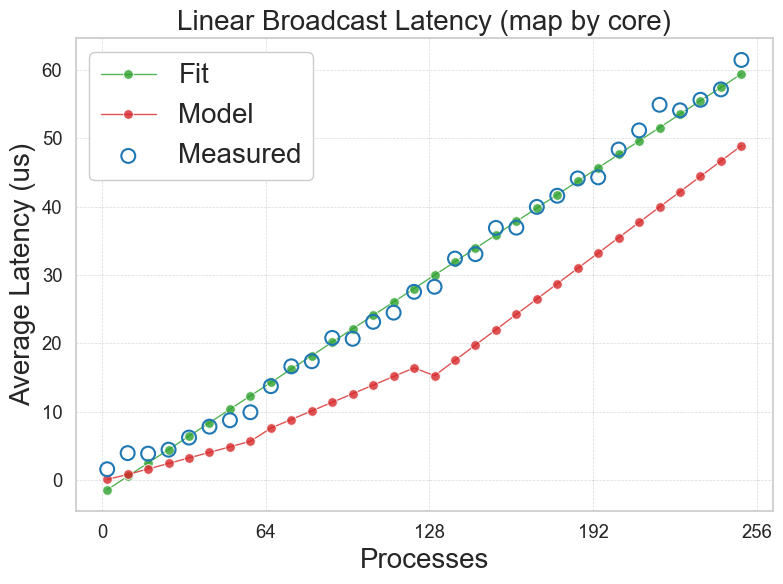

In [15]:
# Model ------------------------------------------------------------------------

# Select a size and segments number and generate data
sizestop = 2**0
ns = 1
# x = df[df['size']==sizestop]['cores'].sort_values().unique()
x = np.arange(2, 256, 8)

# Initialize the nodes with MPI processes
p = initialize(node1, node2, n_processes=256, mapby='core')
y_m = [linear_bcast(p[:core], sizestop) for core in x]

# FIt
y_f = [linear(core) for core in x]

# keep in the df ponly the values corresponding to the values in x
df = df[df['cores'].isin(x)]

# DO the varage if there are multiple latency values corresponding to one same value of cores
df = df.groupby('cores').mean().reset_index()

# PLOT -------------------------------------------------------------------------

plt.figure(figsize=(width,height))

# Set Seaborn theme, grid aesthetic and Matplotlib background and figure size
sns.set_theme(style="whitegrid", palette="tab10", rc={"grid.linestyle": "--", "grid.color": "gray", "grid.alpha": 0.3, "grid.linewidth": 0.5})

# Data, Mopdel and Fit compared
# sns.scatterplot(data=df, x='cores', y='latency', marker='o', s=40, label='Measured', color='tab:blue', alpha = 0.8)
sns.lineplot(x=x, y=y_f, label='Fit', linewidth=1, marker='o', markersize=7, color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', linewidth=1, marker='o', markersize=7, color='tab:red', alpha =0.8)
plt.scatter(df['cores'], df['latency'], linewidth=1.5, marker='o', s=100, label='Measured', edgecolors='tab:blue', alpha = 1, facecolors='none', zorder=10)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by core)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
plt.ylabel('Average Latency (us)', fontsize=fontsize)
plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()
plt.show()

#### Socket

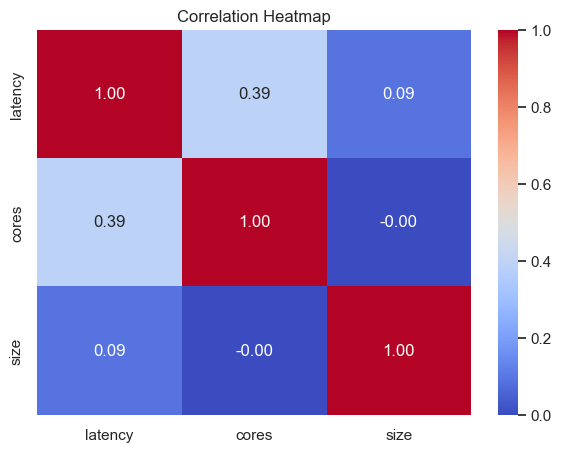

In [43]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfs[dfs['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [8]:
# Linear Fit
df = dfs.copy()

# ---


# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
# df['cores_group1'] = df['cores'] * df['group_node1']
df['cores_group2'] = df['cores'] * df['group_node2']


# ---

# Filter small message size
sizestop = 1
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores', 'group_node2', 'cores_group2']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    if cores > 128:
        return beta['const'] + beta['cores'] * cores + beta['group_node2'] + beta['cores_group2'] * cores
    else:
        return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.788e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.57e-223
Time:                        11:39:14   Log-Likelihood:                -206.33
No. Observations:                 185   AIC:                             420.7
Df Residuals:                     181   BIC:                             433.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4614      0.152      3.028   

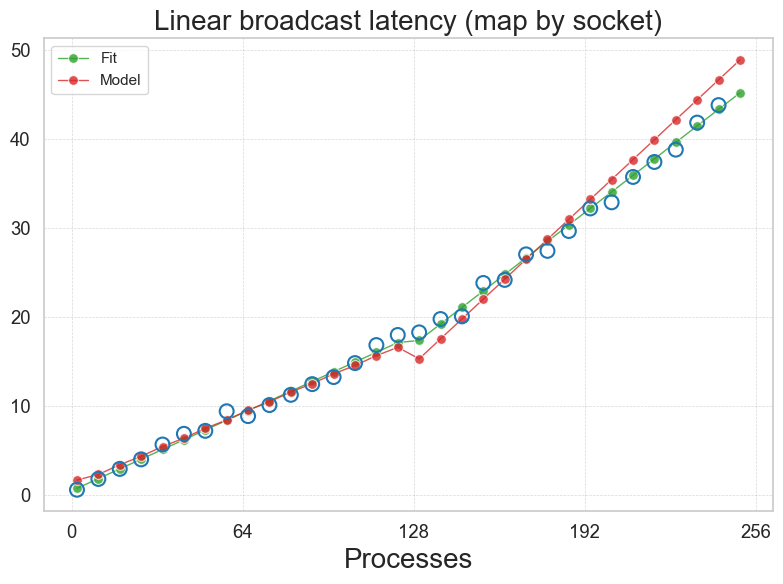

In [9]:
# Model ------------------------------------------------------------------------

# Select a size and segments number and generate data
sizestop = 2**0
ns = 1
# x = df[df['size']==sizestop]['cores'].sort_values().unique()
x = np.arange(2, 256, 8)

# Initialize the nodes with MPI processes
p = initialize(node1, node2, n_processes=256, mapby='socket')
y_m = [linear_bcast(p[:core], sizestop) for core in x]

# FIt
y_f = [linear(core) for core in x]

# keep in the df ponly the values corresponding to the values in x
df = df[df['cores'].isin(x)]

# DO the varage if there are multiple latency values corresponding to one same value of cores
df = df.groupby('cores')['latency'].mean().reset_index()

# PLOT -------------------------------------------------------------------------

plt.figure(figsize=(width,height))

# Set Seaborn theme, grid aesthetic and Matplotlib background and figure size
sns.set_theme(style="whitegrid", palette="tab10", rc={"grid.linestyle": "--", "grid.color": "gray", "grid.alpha": 0.3, "grid.linewidth": 0.5})

# Data, Mopdel and Fit compared
# sns.scatterplot(data=df, x='cores', y='latency', marker='o', s=40, label='Measured', color='tab:blue', alpha = 0.8)
sns.lineplot(x=x, y=y_f, label='Fit', linewidth=1, marker='o', markersize=7, color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', linewidth=1, marker='o', markersize=7, color='tab:red', alpha =0.8)
plt.scatter(df['cores'], df['latency'], linewidth=1.5, marker='o', s=100, label='Measured', edgecolors='tab:blue', alpha = 1, facecolors='none', zorder=10)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by socket)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()
plt.show()

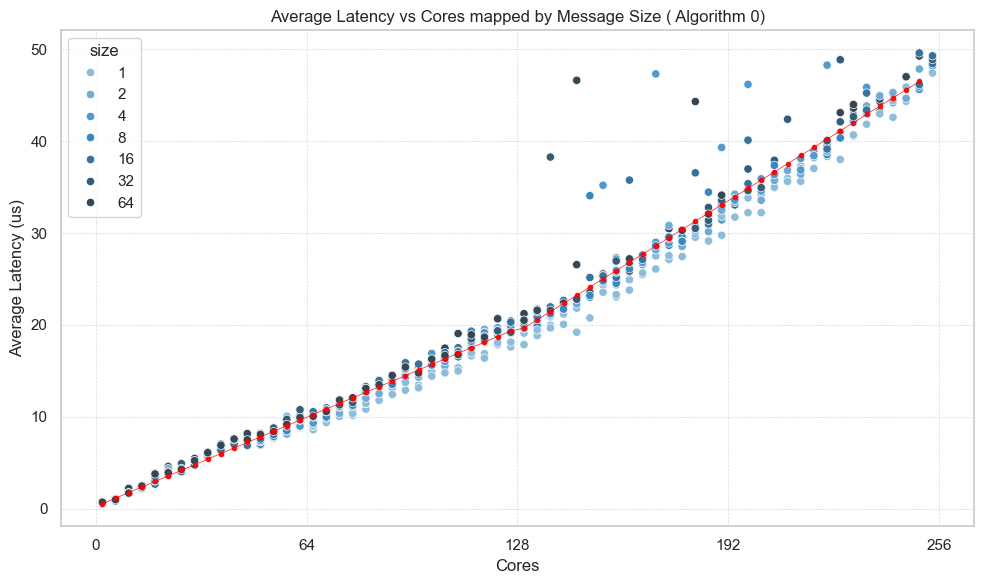

In [67]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size ( Algorithm 0)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Node

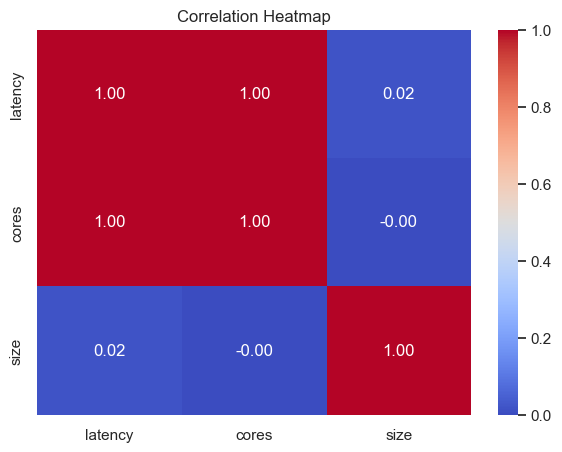

In [ ]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfn[dfn['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [12]:
# Linear Fit
df = dfn.copy()

# Filter small message size
sizestop = 1
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.372e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           1.77e-74
Time:                        11:41:14   Log-Likelihood:                -103.37
No. Observations:                  64   AIC:                             210.7
Df Residuals:                      62   BIC:                             215.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.8652      0.309     -6.035      0.0

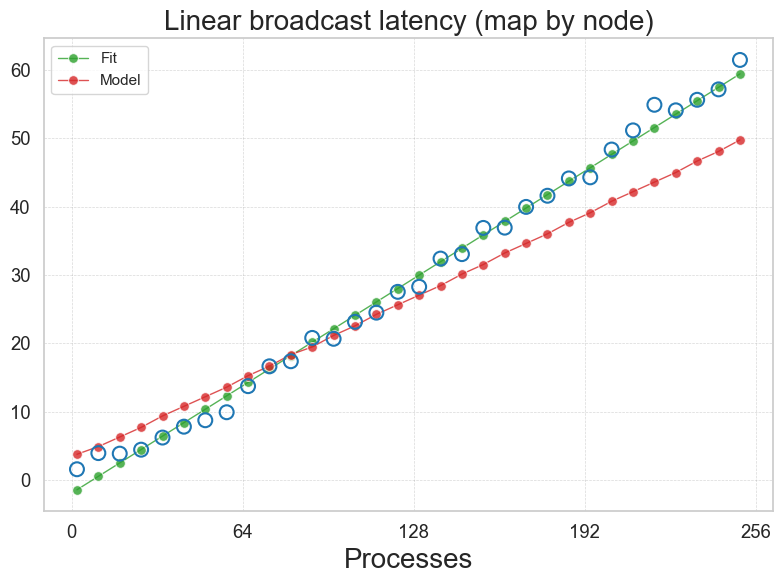

In [13]:

# Model ------------------------------------------------------------------------

# Select a size and segments number and generate data
sizestop = 2**0
ns = 1
# x = df[df['size']==sizestop]['cores'].sort_values().unique()
x = np.arange(2, 256, 8)

# Initialize the nodes with MPI processes
p = initialize(node1, node2, n_processes=256, mapby='node')
y_m = [linear_bcast(p[:core], sizestop) for core in x]

# FIt
y_f = [linear(core) for core in x]

# keep in the df ponly the values corresponding to the values in x
df = df[df['cores'].isin(x)]

# DO the varage if there are multiple latency values corresponding to one same value of cores
df = df.groupby('cores')['latency'].mean().reset_index()

# PLOT -------------------------------------------------------------------------

plt.figure(figsize=(width,height))

# Set Seaborn theme, grid aesthetic and Matplotlib background and figure size
sns.set_theme(style="whitegrid", palette="tab10", rc={"grid.linestyle": "--", "grid.color": "gray", "grid.alpha": 0.3, "grid.linewidth": 0.5})

# Data, Mopdel and Fit compared
# sns.scatterplot(data=df, x='cores', y='latency', marker='o', s=40, label='Measured', color='tab:blue', alpha = 0.8)
sns.lineplot(x=x, y=y_f, label='Fit', linewidth=1, marker='o', markersize=7, color='tab:green', alpha =0.8)
sns.lineplot(x=x, y=y_m, label='Model', linewidth=1, marker='o', markersize=7, color='tab:red', alpha =0.8)
plt.scatter(df['cores'], df['latency'], linewidth=1.5, marker='o', s=100, label='Measured', edgecolors='tab:blue', alpha = 1, facecolors='none', zorder=10)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks, fontsize=fontsize*2/3)
plt.yticks(fontsize=fontsize*2/3)
plt.title('Linear Broadcast Latency (map by node)', fontsize=fontsize)
plt.xlabel('Processes', fontsize=fontsize)
# plt.ylabel('Average Latency (us)', fontsize=fontsize)
# plt.legend(loc = 'upper left', framealpha=1, fontsize=fontsize)
plt.tight_layout()
plt.show()

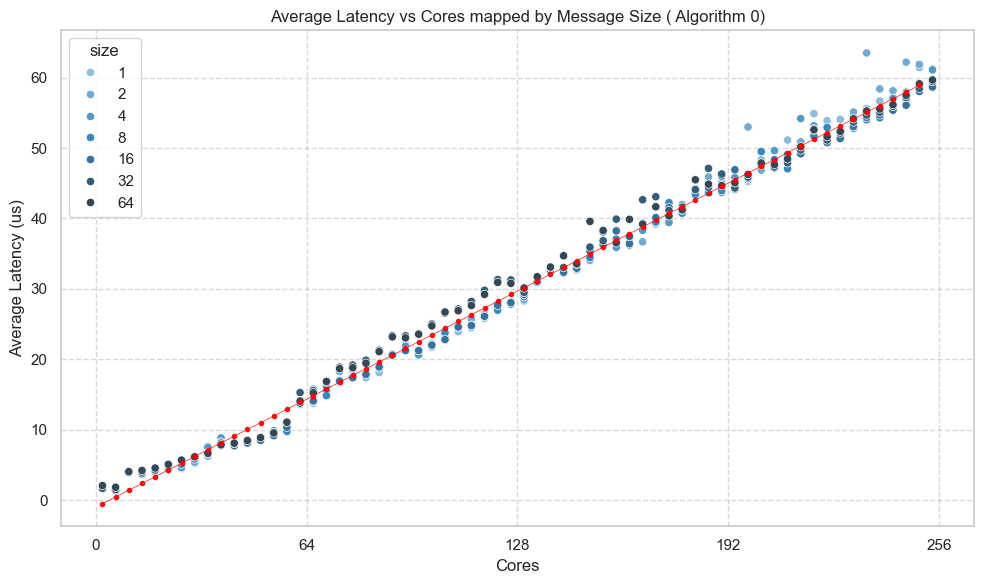

In [51]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size ( Algorithm 0)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

***

## Algorithm 2: Chain

### EDA

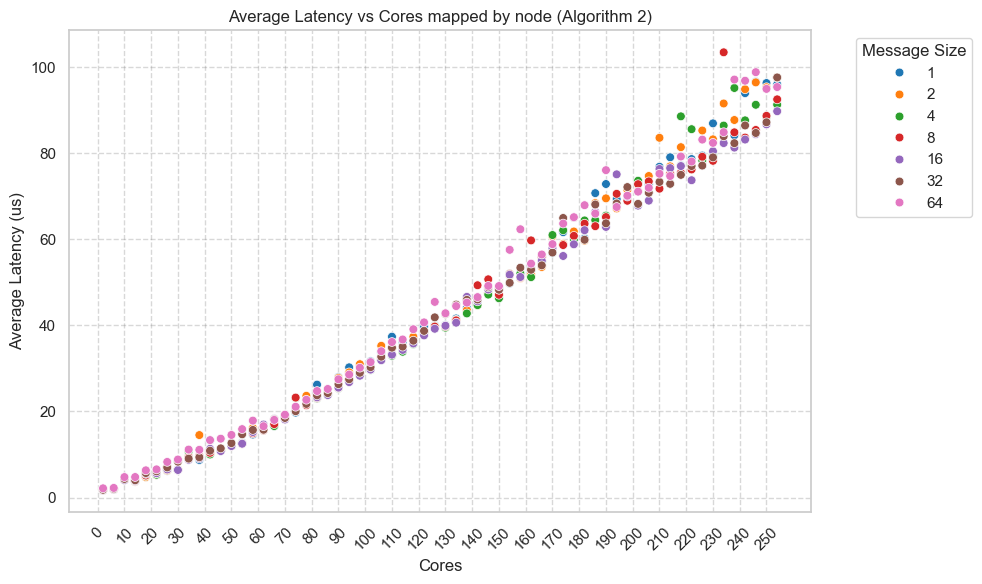

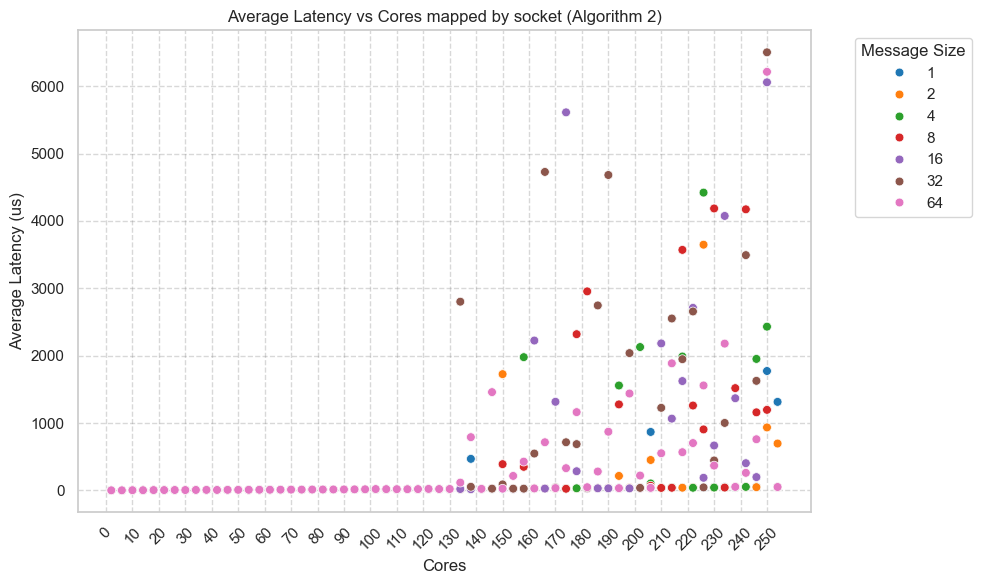

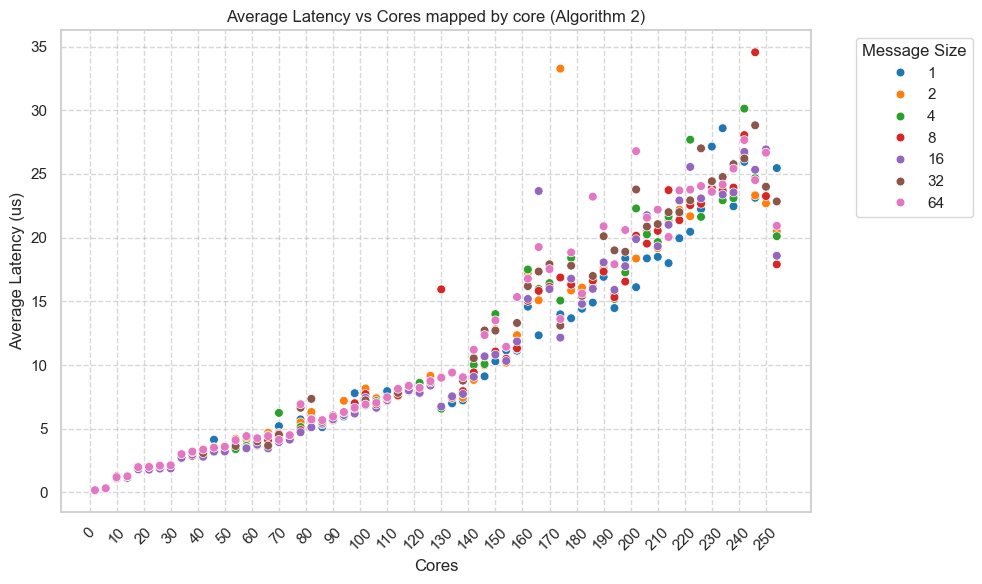

In [54]:
dfn = preproc(node_file, 'node', 2)
dfs = preproc(socket_file, 'socket', 2)
dfc = preproc(core_file, 'core', 2)

sizestop = 64
latency_vs_cores(dfn[dfn['size']<=sizestop], '2', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '2', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '2', 'core')

### Data cleaning

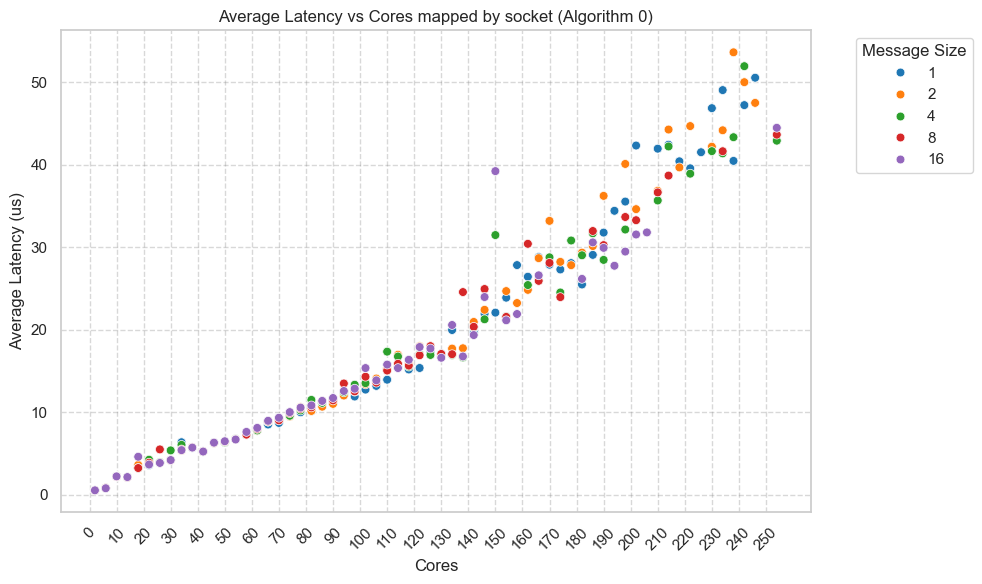

In [55]:
# Cleaning visualization
sizestart = 0
sizestop = 16
cut = 60
latency_vs_cores(dfs[((dfs['size']>=sizestart) & (dfs['size']<=sizestop) & (dfs['latency']<=cut))], '0', 'socket')

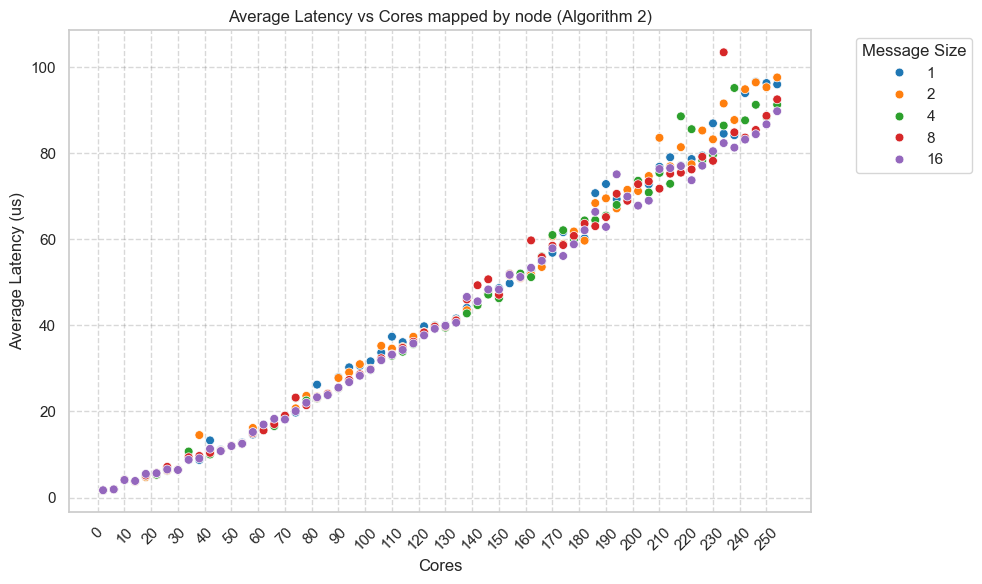

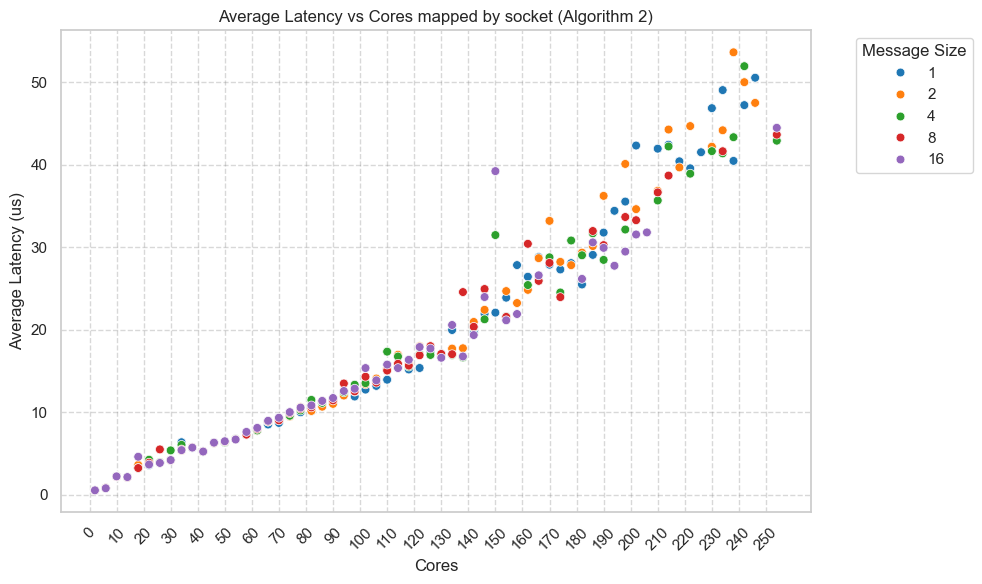

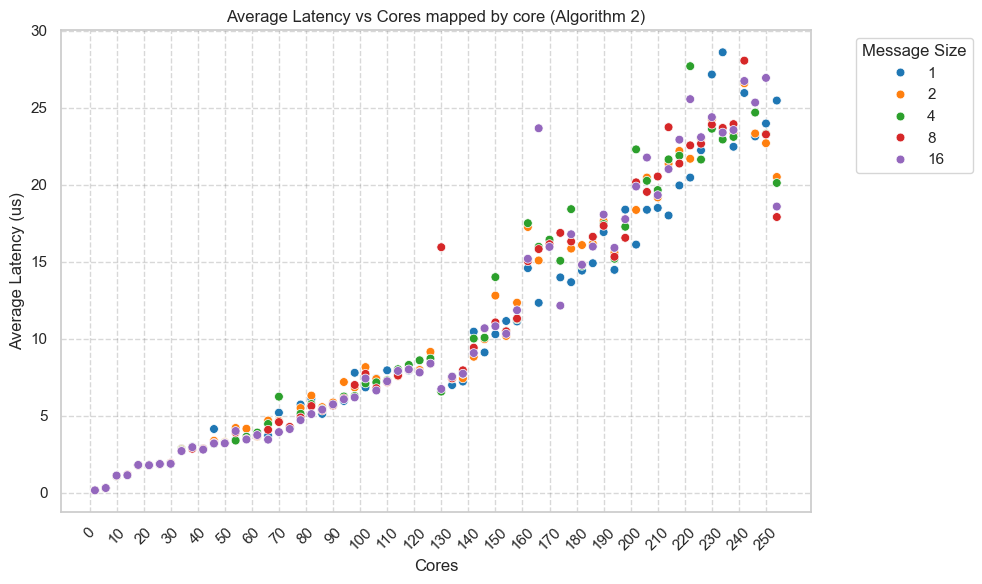

In [56]:
# Remove outliers in dfs
dfs = dfs[~((dfs['size']<=16) & (dfs['latency']>60))]
dfc = dfc[~((dfc['size']<=16) & (dfc['latency']>30))]
# dfs = dfs[~((dfs['size']>=256) & (dfs['size']<=512) & (dfs['latency']>17.5))]
# dfs = dfs[~((dfs['size']>=1024) & (dfs['size']<=2048) & (dfs['latency']>25))]
# dfs = dfs[~((dfs['size']>=4096) & (dfs['size']<=8192) & (dfs['latency']>60))]

# Check
sizestop = 16
latency_vs_cores(dfn[dfn['size']<=sizestop], '2', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '2', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '2', 'core')

### Linear Fit

#### Core

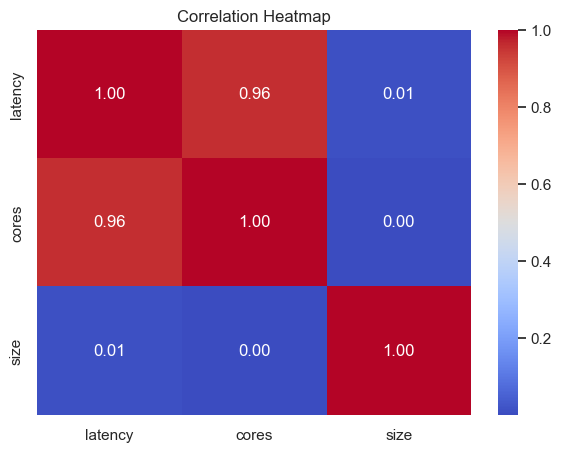

In [57]:
sizestop = 16

# Computing the correlation matrix 
correlation_matrix =  dfc[dfc['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [59]:
# Linear Fit
df = dfc.copy()

# ---

# # Group by the node:
# # Add a categorical column to group depending on the cores
# df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
# df['group'] = df['group'].astype('category')

# # Create dummy variables for the 'group' column
# group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
# df = pd.concat([df, group_dummies], axis=1)

# # Create interaction terms with the cores
# # df['cores_group1'] = df['cores'] * df['group_node1']
# df['cores_group2'] = df['cores'] * df['group_node2']

# Group by the socket:
# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 64, 128, 192, 256], labels=['socket1', 'socket2', 'socket3', 'socket4'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
df['cores_group2'] = df['cores'] * df['group_socket2']
df['cores_group3'] = df['cores'] * df['group_socket3']
df['cores_group4'] = df['cores'] * df['group_socket4']

# ---

# Filter small message size
sizestop = 16
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores', 'group_socket2', 'cores_group2', 'group_socket3', 'cores_group3', 'group_socket4', 'cores_group4']]
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    if cores <= 64:
        return beta['const'] + beta['cores'] * cores
    elif cores > 64 and cores <= 128:
        return beta['const'] + beta['cores'] * cores + beta['group_socket2'] + beta['cores_group2'] * cores
    elif cores > 128 and cores <= 192:
        return beta['const'] + beta['cores'] * cores + beta['group_socket3'] + beta['cores_group3'] * cores
    else:
        return beta['const'] + beta['cores'] * cores + beta['group_socket4'] + beta['cores_group4'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.958
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     1004.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          2.36e-208
Time:                        09:55:17   Log-Likelihood:                -597.33
No. Observations:                 317   AIC:                             1211.
Df Residuals:                     309   BIC:                             1241.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.3240      0.361      0.897

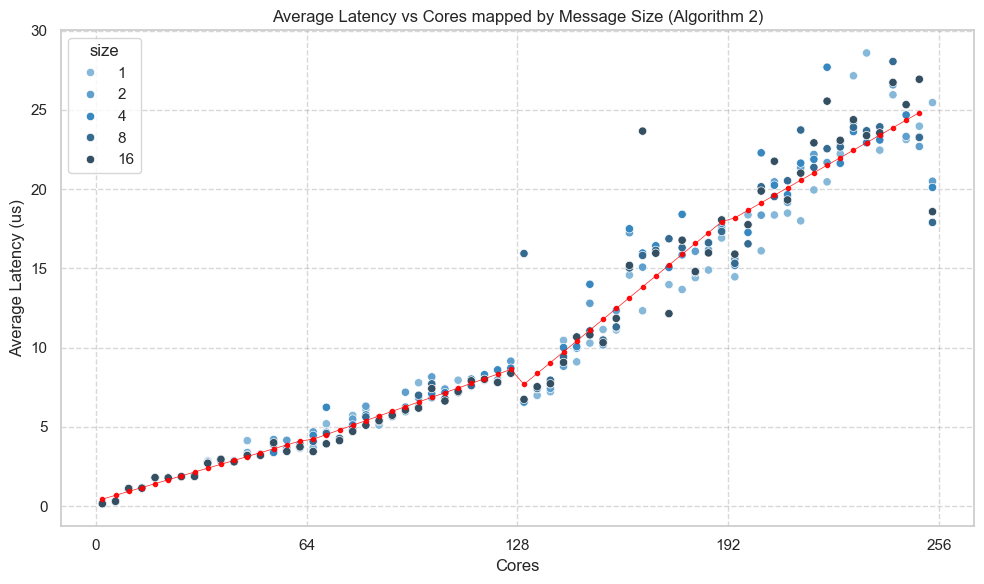

In [60]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 2)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Socket

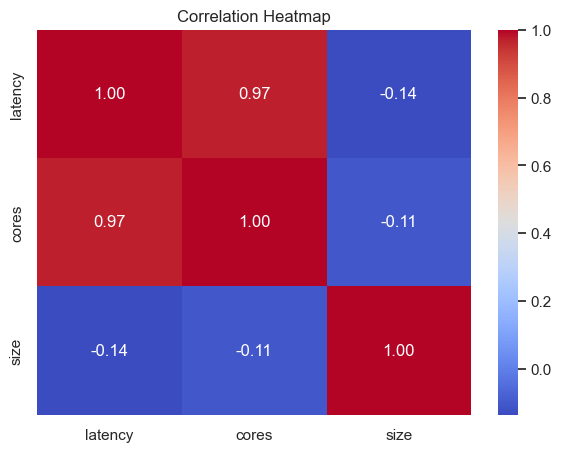

In [ ]:
sizestop = 16

# Computing the correlation matrix 
correlation_matrix =  dfs[dfs['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [61]:
# Linear Fit
df = dfs.copy()

# ---


# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
# df['cores_group1'] = df['cores'] * df['group_node1']
df['cores_group2'] = df['cores'] * df['group_node2']


# ---

# Filter small message size
sizestop = 16
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores', 'group_node2', 'cores_group2']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    if cores > 128:
        return beta['const'] + beta['cores'] * cores + beta['group_node2'] + beta['cores_group2'] * cores
    else:
        return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.971
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     6038.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        09:55:28   Log-Likelihood:                -1214.6
No. Observations:                 546   AIC:                             2437.
Df Residuals:                     542   BIC:                             2454.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.4001      0.251      1.592   

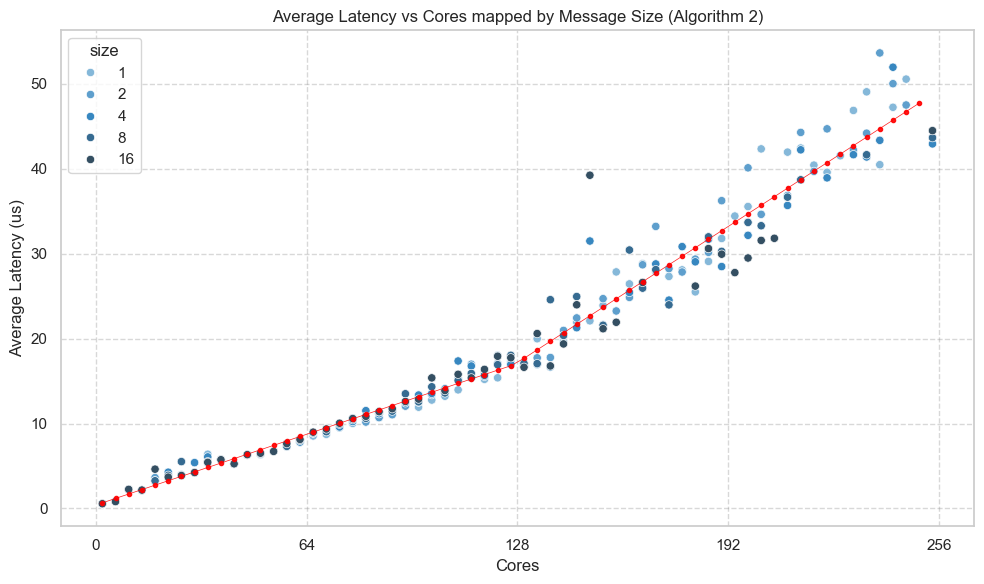

In [62]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 2)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Node

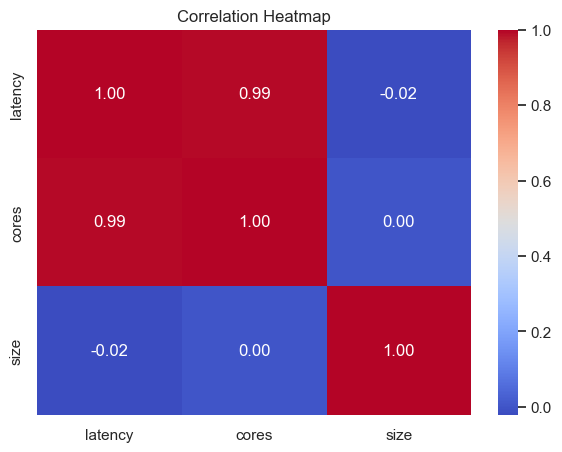

In [63]:
sizestop = 16

# Computing the correlation matrix 
correlation_matrix =  dfn[dfn['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [64]:
# Linear Fit
df = dfn.copy()

# Filter small message size
sizestop = 16
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
def linear(cores):
    return beta['const'] + beta['cores'] * cores

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                 2.121e+04
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          3.98e-293
Time:                        09:55:50   Log-Likelihood:                -848.24
No. Observations:                 320   AIC:                             1700.
Df Residuals:                     318   BIC:                             1708.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.6536      0.384    -14.706      0.0

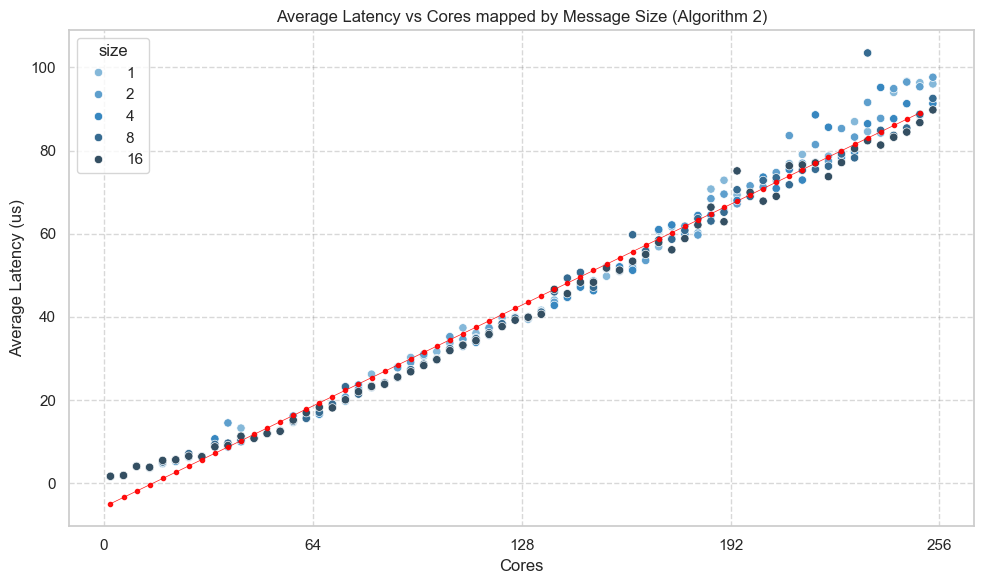

In [65]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 2)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

***

## Algorithm 5: Binary Tree

### EDA

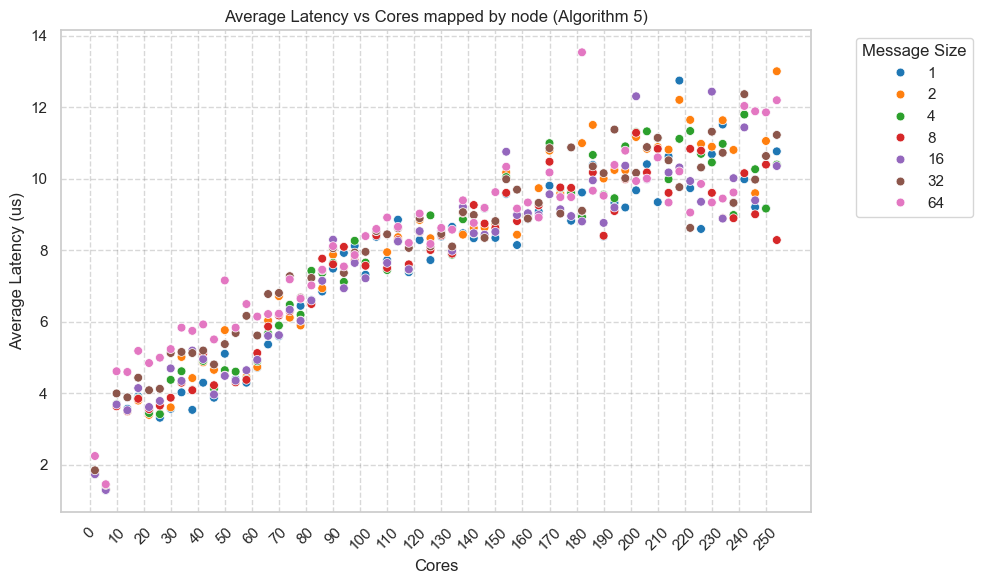

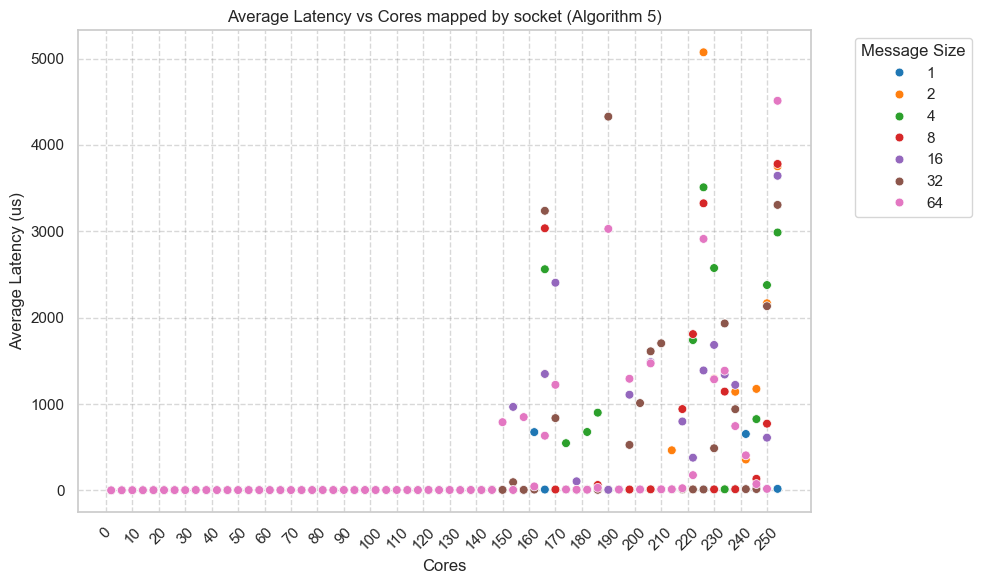

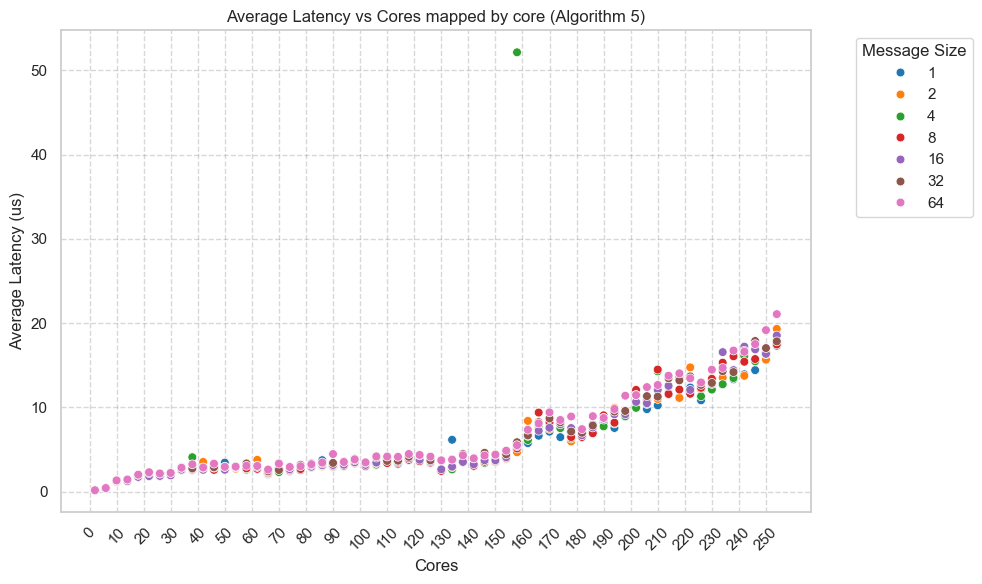

In [66]:
dfn = preproc(node_file, 'node', 5)
dfs = preproc(socket_file, 'socket', 5)
dfc = preproc(core_file, 'core', 5)

sizestop = 64
latency_vs_cores(dfn[dfn['size']<=sizestop], '5', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '5', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '5', 'core')

### Data cleaning

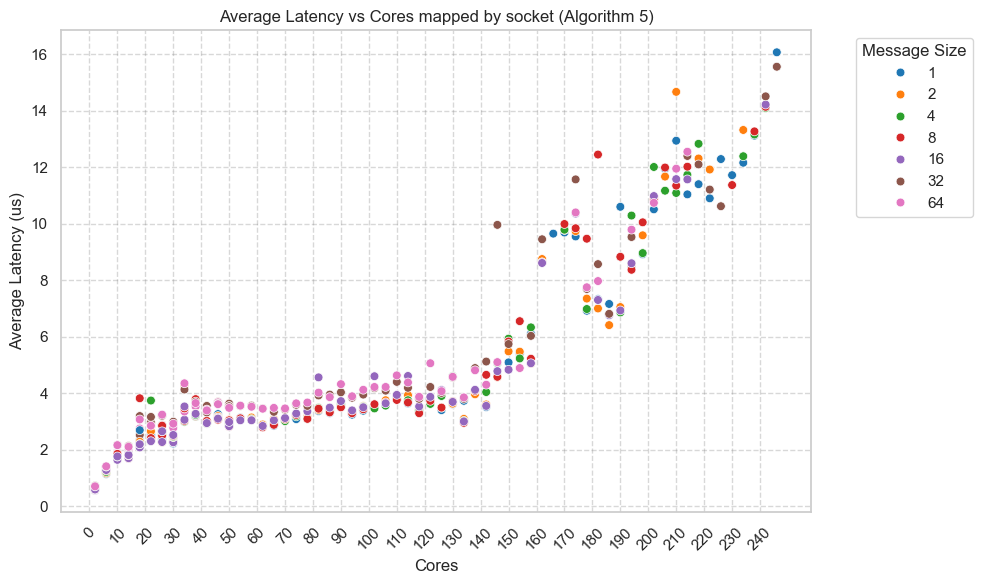

In [67]:
# Cleaning visualization
sizestart = 0
sizestop = 64
cut = 17.0
latency_vs_cores(dfs[((dfs['size']>=sizestart) & (dfs['size']<=sizestop) & (dfs['latency']<=cut))], '5', 'socket')

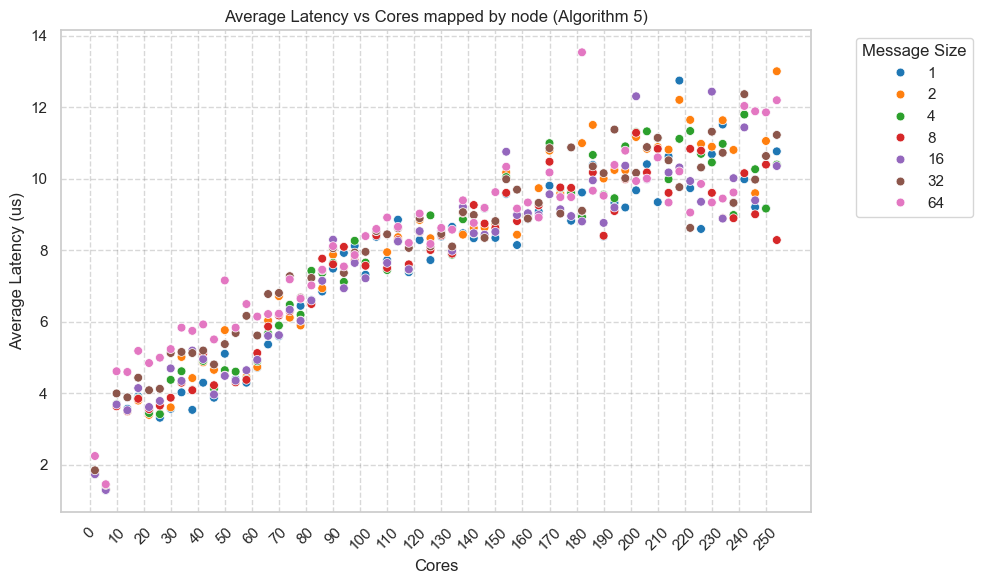

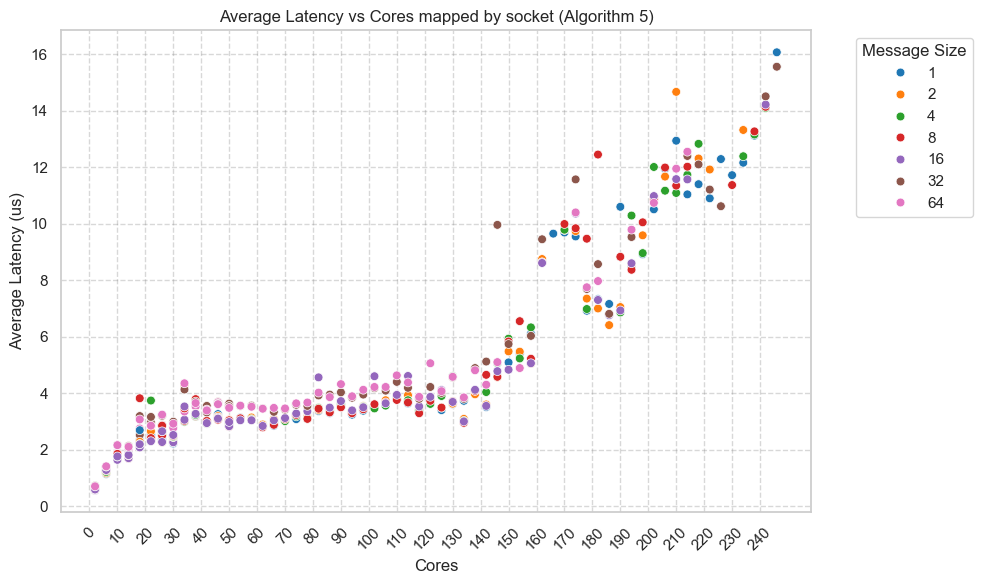

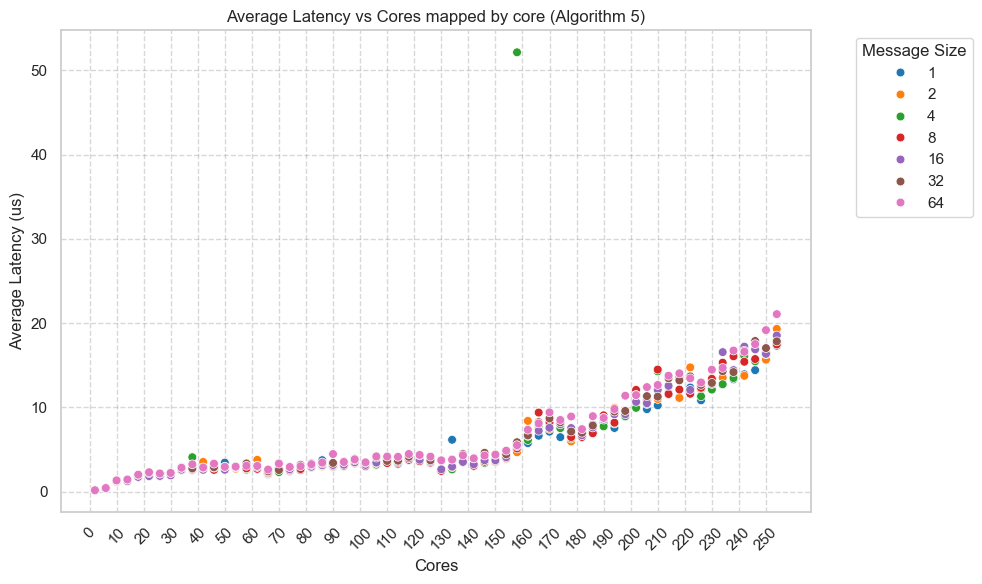

In [68]:
# Remove outliers in dfs
dfs = dfs[~((dfs['size']<=64) & (dfs['latency']>17))]
# dfs = dfs[~((dfs['size']>=256) & (dfs['size']<=512) & (dfs['latency']>17.5))]
# dfs = dfs[~((dfs['size']>=1024) & (dfs['size']<=2048) & (dfs['latency']>25))]
# dfs = dfs[~((dfs['size']>=4096) & (dfs['size']<=8192) & (dfs['latency']>60))]

# Check
sizestop = 64
latency_vs_cores(dfn[dfn['size']<=sizestop], '5', 'node')
latency_vs_cores(dfs[dfs['size']<=sizestop], '5', 'socket')
latency_vs_cores(dfc[dfc['size']<=sizestop], '5', 'core')

### Linear Fit

#### Core

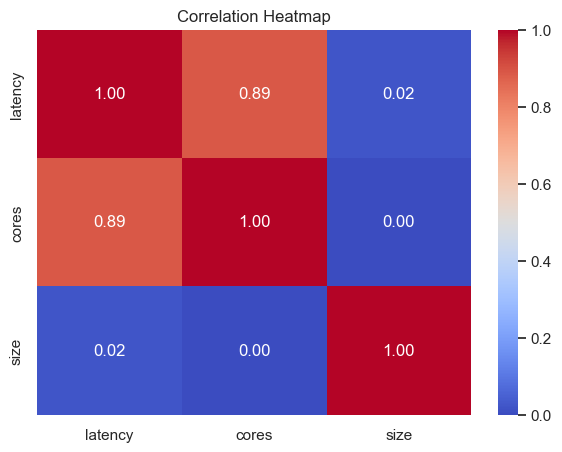

In [ ]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfc[dfc['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [74]:
# Linear Fit
df = dfc.copy()

# ---

# # Group by the node:
# # Add a categorical column to group depending on the cores
# df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
# df['group'] = df['group'].astype('category')

# # Create dummy variables for the 'group' column
# group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
# df = pd.concat([df, group_dummies], axis=1)

# # Create interaction terms with the cores
# # df['cores_group1'] = df['cores'] * df['group_node1']
# df['cores_group2'] = df['cores'] * df['group_node2']

# Add two columns, one for the logarithm of the cores and one for the square of the cores
df['log_cores'] = np.log2(df['cores'])
df['cores2'] = df['cores'] ** 2

# Group by the socket:
# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 64, 128, 192, 256], labels=['socket1', 'socket2', 'socket3', 'socket4'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
df['cores_group2'] = df['log_cores'] * df['group_socket2']
df['cores_group3'] = df['cores2'] * df['group_socket3']
df['cores_group4'] = df['cores2'] * df['group_socket4']

# ---

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['log_cores', 'cores2', 'group_socket2', 'cores_group2', 'group_socket3', 'cores_group3', 'group_socket4', 'cores_group4']]
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
# def linear(cores):
#     if cores <= 64:
#         return beta['const'] + beta['cores'] * cores
#     elif cores > 64 and cores <= 128:
#         return beta['const'] + beta['cores'] * cores + beta['group_socket2'] + beta['cores_group2'] * cores
#     elif cores > 128 and cores <= 192:
#         return beta['const'] + beta['cores'] * cores + beta['group_socket3'] + beta['cores_group3'] * cores
#     else:
#         return beta['const'] + beta['cores'] * cores + beta['group_socket4'] + beta['cores_group4'] * cores

def linear(cores):
    if cores <= 64:
        return beta['const'] + beta['log_cores'] * np.log2(cores) + beta['cores2'] * cores ** 2
    elif cores > 64 and cores <= 128:
        return beta['const'] + beta['log_cores'] * np.log2(cores) + beta['cores2'] * cores ** 2 + beta['group_socket2'] + beta['cores_group2'] * np.log2(cores)
    elif cores > 128 and cores <= 192:
        return beta['const'] + beta['log_cores'] * np.log2(cores) + beta['cores2'] * cores ** 2 + beta['group_socket3'] + beta['cores_group3'] * cores ** 2
    else:
        return beta['const'] + beta['log_cores'] * np.log2(cores) + beta['cores2'] * cores ** 2 + beta['group_socket4'] + beta['cores_group4'] * cores ** 2


                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.789
Method:                 Least Squares   F-statistic:                     210.1
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          6.99e-145
Time:                        10:00:10   Log-Likelihood:                -1017.8
No. Observations:                 448   AIC:                             2054.
Df Residuals:                     439   BIC:                             2091.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.9732      0.940     -1.036

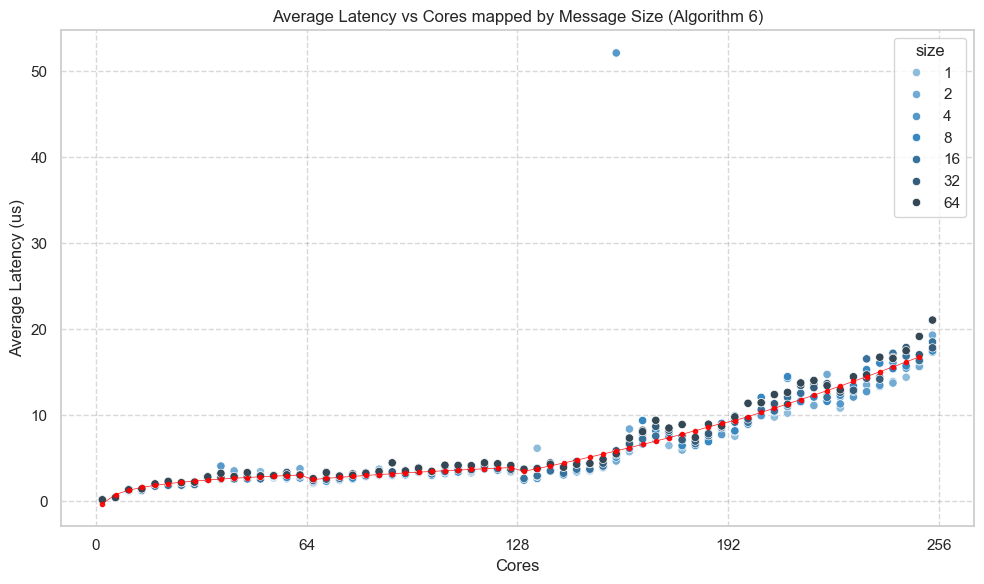

In [75]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 5)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Socket

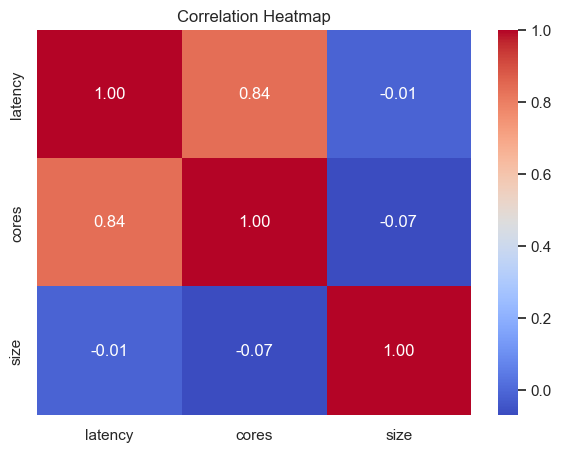

In [ ]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfs[dfs['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [76]:
# Linear Fit
df = dfs.copy()

# ---


# Add two columns, one for the logarithm of the cores and one for the square of the cores
df['log_cores'] = np.log(df['cores'])
df['cores2'] = df['cores'] ** 2

# Add a categorical column to group depending on the cores
df['group'] = pd.cut(df['cores'], bins=[0, 128, 256], labels=['node1', 'node2'])
df['group'] = df['group'].astype('category')

# Create dummy variables for the 'group' column
group_dummies = pd.get_dummies(df['group'], prefix='group', drop_first=True).astype(int)
df = pd.concat([df, group_dummies], axis=1)

# Create interaction terms with the cores
# df['cores_group1'] = df['cores'] * df['group_node1']
df['cores_group2'] = df['cores2'] * df['group_node2']


# ---

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['log_cores', 'cores2', 'group_node2', 'cores_group2']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
# def linear(cores):
#     if cores > 128:
#         return beta['const'] + beta['cores'] * cores + beta['group_node2'] + beta['cores_group2'] * cores
#     else:
#         return beta['const'] + beta['cores'] * cores

def linear(cores):
    if cores > 128:
        return beta['const'] + beta['log_cores'] * np.log(cores) + beta['cores2'] * cores ** 2 + beta['group_node2'] + beta['cores_group2'] * cores ** 2
    else:
        return beta['const'] + beta['log_cores'] * np.log(cores) + beta['cores2'] * cores ** 2

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     1633.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          2.69e-268
Time:                        10:00:26   Log-Likelihood:                -565.55
No. Observations:                 460   AIC:                             1141.
Df Residuals:                     455   BIC:                             1162.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.1177      0.215     -0.548   

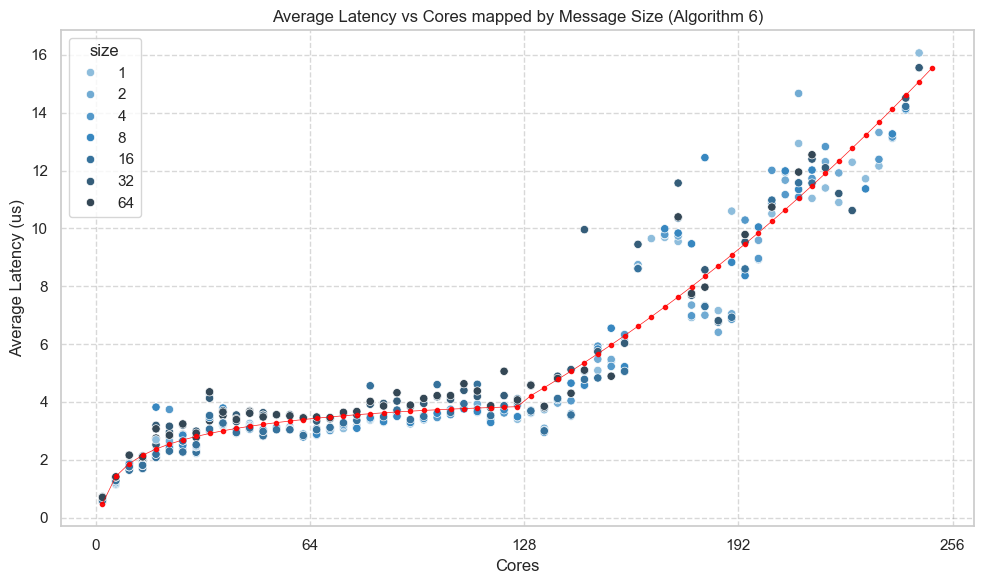

In [77]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 5)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()

#### Node

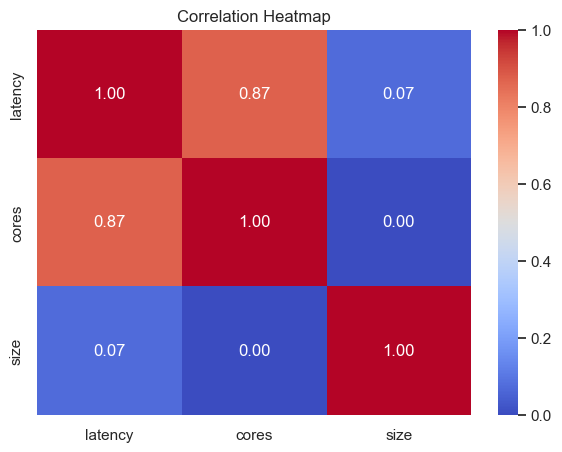

In [ ]:
sizestop = 64

# Computing the correlation matrix 
correlation_matrix =  dfn[dfn['size']<=sizestop][['latency', 'cores', 'size']].corr()

# Plot the heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title(f"Correlation Heatmap")
plt.show()

In [78]:
# Linear Fit
df = dfn.copy()

# Add a log_cores column
df['log_cores'] = np.log(df['cores'])

# Filter small message size
sizestop = 64
df = df[df['size'] <= sizestop]

# Define dependent variable
y = df['latency']

# Define independent variables
X = df[['log_cores']] # covariates
X = sm.add_constant(X)    # intercept

# Define the model - OLS stands for "ordinary least squares"
model = sm.OLS(y, X)

# Fit the model
fit = model.fit()

# Coefficients
beta = fit.params

# Print the summary
print(fit.summary())

# Define functions using the coefficients
# def linear(cores):
#     return beta['const'] + beta['cores'] * cores

def linear(cores):
    return beta['const'] + beta['log_cores'] * np.log(cores)

                            OLS Regression Results                            
Dep. Variable:                latency   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     2254.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):          1.65e-176
Time:                        10:01:21   Log-Likelihood:                -656.71
No. Observations:                 448   AIC:                             1317.
Df Residuals:                     446   BIC:                             1326.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2293      0.238    -13.574      0.0

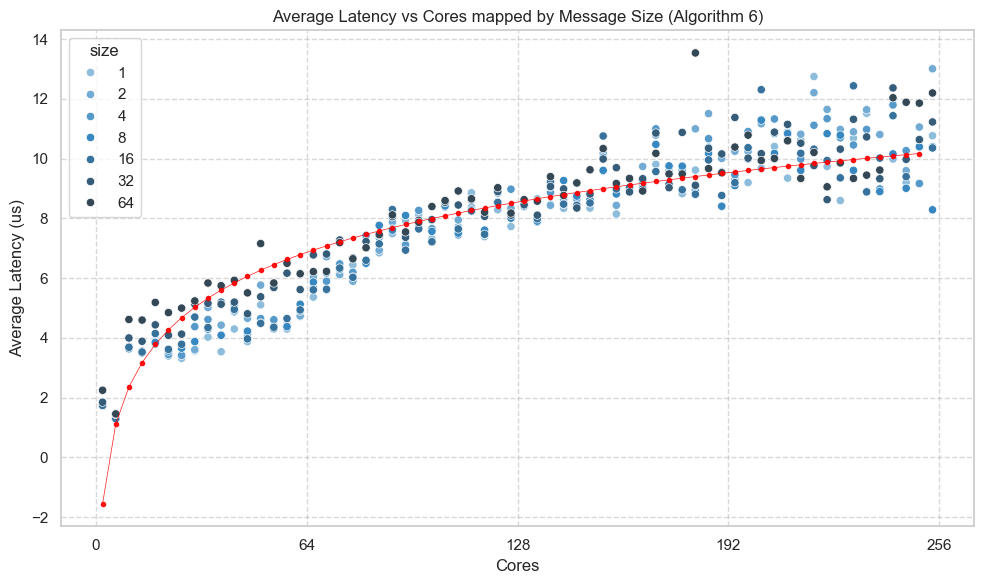

In [79]:
# Plot the result of the fit vs the data for fized message size
plt.figure(figsize=(10, 6))

# Color palette
# Get the number of unique sizes
num_sizes = df['size'].nunique()

# Generate a palette with a color for each size
palette = sns.color_palette("Blues_d", num_sizes)

# Create a dictionary mapping each size to a color
size_palette = {size: palette[i] for i, size in enumerate(df['size'].unique())}

# Data
sns.scatterplot(data=df, x='cores', y='latency', hue='size', palette=size_palette, legend=True)

# Fitted curves
# x = np.linspace(0, 254, 100)
x = np.arange(2, 254, 4)
y = [linear(i) for i in x]

plt.plot(x, y, label='Linear Fit', color='red', linestyle='-', linewidth=0.5, marker='.', alpha=0.9)

# Labels
x_ticks = [0, 64, 128, 192, 256]
plt.xticks(x_ticks, x_ticks)
plt.title('Average Latency vs Cores mapped by Message Size (Algorithm 5)')
plt.xlabel('Cores')
plt.ylabel('Average Latency (us)')
plt.tight_layout()
plt.show()